In [1]:
import torch
torch.cuda.set_device(7)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 7
Current default GPU name: NVIDIA A40


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
def l2_normalize(features):
    # Compute the L2 norm for each row (dim=1)
    norms = torch.norm(features, p=2, dim=1, keepdim=True)
    # Divide each element by its norm
    normalized_features = features / norms
    return normalized_features

In [4]:
syn = torch.load('saved_data/featurex_realfromreal_s5g2.pth')
real = torch.load('saved_data/featurey_real.pth')

all_x = torch.cat([syn[i] for i in sorted(syn.keys())], dim=0)
all_y = torch.cat([real[i] for i in sorted(real.keys())], dim=0)

In [6]:
print(all_x)

tensor([[-0.8976,  1.5207,  0.6173,  ...,  1.0619, -1.8411, -1.1478],
        [-3.1857,  3.2636, -0.7233,  ..., -1.9798,  0.3992,  0.7591],
        [-2.4545,  1.2019,  0.7781,  ..., -0.0697, -0.4357, -1.1823],
        ...,
        [-1.2353, -1.0662, -1.7338,  ...,  0.3138, -2.3514, -0.8966],
        [-0.3701, -1.0825, -0.2542,  ...,  0.3410, -2.8227, -1.1760],
        [ 0.8975, -2.0137, -1.5854,  ..., -0.4322, -2.4853, -1.9273]])


In [5]:
all_x, all_y = l2_normalize(all_x), l2_normalize(all_y)

In [9]:
syn_np = all_x.numpy()
real_np = all_y.numpy()

In [10]:
real_syn = np.concatenate((syn_np, real_np), axis=0)

In [11]:
# Initialize PCA to reduce the data to 2 components
pca = PCA(n_components=2)

# Fit PCA on the data and transform the data
realsyn_pca = pca.fit_transform(real_syn)


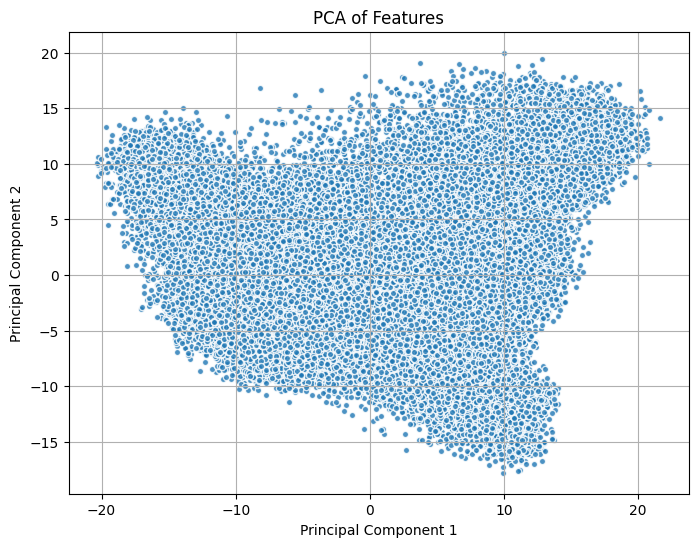

In [12]:
# Plotting the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(realsyn_pca[:, 0], realsyn_pca[:, 1], alpha=0.8, edgecolors='w', s=20)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [13]:
# Initialize PCA to reduce the data to 2 components
pca = PCA(n_components=2)

# Fit PCA on the data and transform the data
syn_pca = pca.fit_transform(syn_np)


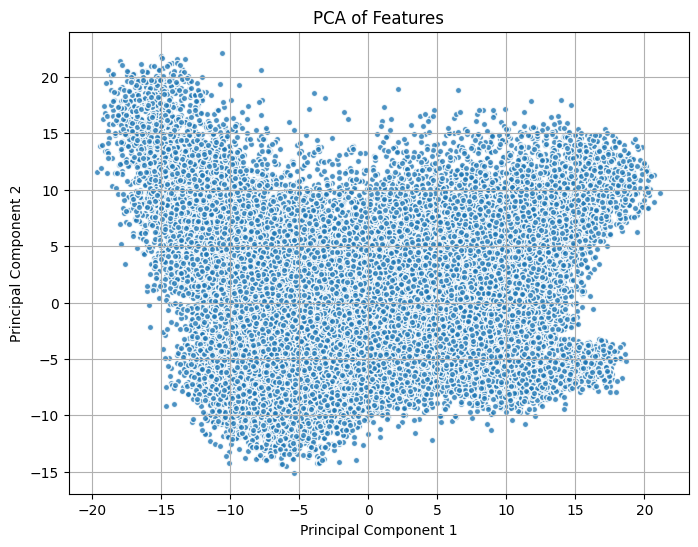

In [14]:
# Plotting the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(syn_pca[:, 0], syn_pca[:, 1], alpha=0.8, edgecolors='w', s=20)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


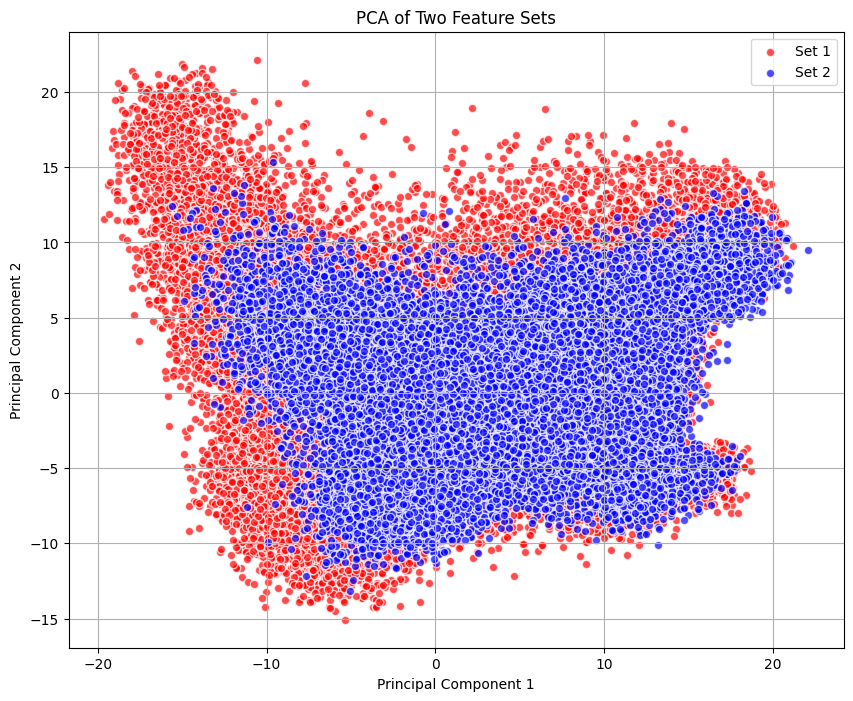

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA to reduce the data to 2 components
pca = PCA(n_components=2)

# Fit and transform PCA on both feature sets
features_pca_set1 = pca.fit_transform(syn_np)
features_pca_set2 = pca.transform(real_np)  # Using the same PCA fit to keep the bases consistent

# Plotting the first two principal components of both feature sets
plt.figure(figsize=(10, 8))
plt.scatter(features_pca_set1[:, 0], features_pca_set1[:, 1], alpha=0.7, color='red', edgecolors='w', label='Set 1')
plt.scatter(features_pca_set2[:, 0], features_pca_set2[:, 1], alpha=0.7, color='blue', edgecolors='w', label='Set 2')
plt.title('PCA of Two Feature Sets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


## feature extraction

In [1]:
import torch.nn as nn
class DINOFeatureExtractor_v2(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
        # self.feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')

        
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.io import read_image

def load_and_transform_images(image_paths_file):
    # Define the image transformations
    transform_to_tensor = transforms.ToTensor()
    
    transform = Compose([
    
    Resize(196),
    # ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4410], std=[0.1941, 0.1917, 0.1957])])
    

    # Read image paths from the text file
    with open(image_paths_file, 'r') as file:
        image_paths = [line.split()[0] for line in file.readlines()]

    # Load images, apply transformations, and stack into a tensor
    # images = [transform(read_image(path).to(torch.float32)) for path in image_paths]
    # img = Image.open(path).convert('RGB')
    # img_tensor = transform_to_tensor(img)
    images = [transform(transform_to_tensor(Image.open(path).convert('RGB'))) for path in image_paths]
    
    batch_images = torch.stack(images)  # Stack images into a batch

    return batch_images



In [3]:
def extract_features(batch_images):
    # Assuming the feature_extractor is a PyTorch model loaded and moved to 'cuda' if available
    with torch.no_grad():  # No need to track gradients for feature extraction
        features = feature_extractor(batch_images.to('cuda')).to('cpu')  # Ensure images are on the same device as the model
    return features

def process_extractfeatures_images_from_files(file_path1, file_path2):
    # Load and transform images from each file
    batch_imagesx = load_and_transform_images(file_path1)
    batch_imagesy = load_and_transform_images(file_path2)

    features_x = extract_features(batch_imagesx)
    features_y = extract_features(batch_imagesy)

    return features_x, features_y



In [ ]:
## create txt files for dataset generation

# for i, t_class in enumerate(order_real):
#     combine_files_with_numbers(x_folder, 
#                                'class', 
#                                t_class, 
#                                x_folder + '_X/') # create txt files for x and y
#     combine_files_with_numbers(y_folder, 
#                                'class', 
#                                t_class, 
#                                y_folder + '_Y/')
#     joined_string = '_'.join(str(integer) for integer in t_class)
#     # output_folder = destination_folder + '_combined/'
#     file_initial = 'class'
#     output_x = x_folder + '_X/' +file_initial+ 'combined' + '_' + joined_string + '.txt' 
#     output_y = y_folder + '_Y/' +file_initial+ 'combined' + '_' + joined_string + '.txt' 
    
#     all_x, all_y = process_extractfeatures_images_from_files(output_x, output_y)
#     syn[i] = all_x
#     real[i] = all_y

In [ ]:
# torch.save(syn, 'saved_data/featurex_realfromreal_s5g2.pth')
# torch.save(real, 'saved_data/featurey_real.pth')
syn = torch.load('saved_data/featurex_realfromreal_s5g2.pth')
real = torch.load('saved_data/featurey_real.pth')

In [ ]:
all_x = torch.cat([syn[i] for i in sorted(syn.keys())], dim=0)
all_y = torch.cat([real[i] for i in sorted(real.keys())], dim=0)